# 환경 준비/임포트
무엇을 하나요? Colab 기본 환경을 확인하고 필요한 라이브러리만 임포트합니다. (추론만 하므로 CPU로 충분)

In [1]:
# 기본 준비
import os, json, math, io
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

try:
    from sklearn.manifold import TSNE
except Exception:
    # 드물게 scikit-learn이 누락된 런타임이 있을 수 있어 설치 시도
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "scikit-learn"])
    from sklearn.manifold import TSNE

print("Torch:", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Torch: 2.8.0+cu126


# 체크포인트(.pth) 업로드

무엇을 하나요? 당신이 Kaggle로 학습해 생성한 .pth 파일을 Colab으로 올립니다.

In [2]:
from google.colab import files
uploaded = files.upload()   # 대화창에서 *.pth 파일 선택
CKPT_PATH = next(iter(uploaded))  # 첫 업로드 파일명
print("Checkpoint path:", CKPT_PATH)

Saving embeddings_epoch2.pth to embeddings_epoch2 (1).pth
Checkpoint path: embeddings_epoch2 (1).pth


# 체크포인트 로더(여러 포맷 자동 인식)
무엇을 하나요? 다양한 저장 포맷을 자동으로 감지해 임베딩 행렬(W) 과 어휘(stoi/itos) 를 안전하게 불러옵니다.

In [3]:
def _maybe_tensor(x):
    if torch.is_tensor(x): return x
    try: return torch.tensor(x)
    except Exception: return None

def load_embeddings_from_checkpoint(path_or_obj):
    # 1) 로드
    ckpt = path_or_obj
    if isinstance(path_or_obj, (str, os.PathLike)):
        ckpt = torch.load(path_or_obj, map_location="cpu")

    if not isinstance(ckpt, dict):
        raise ValueError("Unsupported checkpoint type. Save as a dict via torch.save({...}, path).")

    # 2) 가중치 탐색
    W = ckpt.get("emb_weight")
    if W is not None and not torch.is_tensor(W):
        W = _maybe_tensor(W)
    if W is None:
        # state_dict 후보 키
        sd = ckpt.get("state_dict", {})
        for k in ["emb.weight", "embedding.weight", "encoder.weight", "word_embeddings.weight",
                  "in_embed.weight", "embed.weight"]:
            if k in sd and getattr(sd[k], "ndim", 0) == 2:
                W = sd[k]
                break
    if W is None:
        # dict에서 2D 텐서 아무거나
        for k, v in ckpt.items():
            if torch.is_tensor(v) and v.ndim == 2:
                W = v
                break
    if W is None:
        raise KeyError("2D embedding weight not found in checkpoint.")

    W = W.float().contiguous()

    # 3) vocab
    stoi = ckpt.get("stoi") or ckpt.get("vocab") or ckpt.get("token_to_idx")
    itos = ckpt.get("itos") or ckpt.get("idx_to_token")
    if stoi is None and itos is not None:
        stoi = {w:i for i, w in enumerate(itos)}
    if itos is None and stoi is not None:
        # 안전 복원
        size = max(stoi.values()) + 1
        itos = [None]*size
        for w, i in stoi.items():
            if i < size: itos[i] = w
        if any(v is None for v in itos):
            itos = [w for w,_ in sorted(stoi.items(), key=lambda kv: kv[1])]
    if stoi is None or itos is None:
        raise KeyError("Vocabulary not found. Please include 'stoi' (and optionally 'itos') when saving.")

    meta = ckpt.get("meta", {})
    return W, stoi, itos, meta

W, stoi, itos, meta = load_embeddings_from_checkpoint(CKPT_PATH)
V, D = W.shape
print(f"Loaded embeddings: V={V:,}, D={D}  | meta={meta}")

Loaded embeddings: V=164,802, D=200  | meta={'min_count': 5, 'window': 5, 'negatives': 5, 'lower': True, 'epochs': 2}


# 유사도 검색 유틸(코사인 Top‑k)
무엇을 하나요? 단어를 입력하면 최근접 이웃을 찾아 점수와 함께 출력합니다. (대소문자/표기 변형을 약간 보정)

In [10]:
def _normalize_token(tok: str):
    cands = [tok, tok.lower(), tok.title(), tok.capitalize()]
    seen = set()
    return [t for t in cands if not (t in seen or seen.add(t))]

with torch.no_grad():
    Wn = F.normalize(W, p=2, dim=1)  # (V, D) L2 정규화

def most_similar(query: str, topk: int = 10):
    idx = None
    chosen = None
    for cand in _normalize_token(query):
        idx = stoi.get(cand)
        if idx is not None:
            chosen = cand
            break
    if idx is None:
        return {"query": query, "matched": None, "neighbors": [], "msg": "OOV (not in vocabulary)"}

    qv = Wn[idx]                          # (D,)
    scores = torch.mv(Wn, qv)             # (V,)
    scores[idx] = -1.0                    # 자기 자신 제외
    k = min(topk, Wn.size(0)-1)
    vals, inds = torch.topk(scores, k)
    result = [(itos[i], float(vals[j])) for j, i in enumerate(inds.tolist())]
    return {"query": query, "matched": chosen, "neighbors": result, "msg": "ok"}

def show(query, k=10):
    out = most_similar(query, k)
    if out["matched"] is None:
        print(f"[{query}] -> OOV (not found in vocab)")
        return None
    print(f"Query: {out['query']}  (matched token: '{out['matched']}')")
    for w, s in out["neighbors"]:
        print(f"  {w:20s}  {s:.3f}")
    return out

# 빠른 점검: months
show("september", k=10)

Query: september  (matched token: 'september')
  october               0.845
  august                0.811
  june                  0.795
  november              0.776
  january               0.756
  april                 0.746
  december              0.745
  march                 0.732
  july                  0.721
  february              0.715


{'query': 'september',
 'matched': 'september',
 'neighbors': [('october', 0.8450308442115784),
  ('august', 0.8110421895980835),
  ('june', 0.7951532006263733),
  ('november', 0.7763968706130981),
  ('january', 0.7563741207122803),
  ('april', 0.7463304996490479),
  ('december', 0.744890570640564),
  ('march', 0.7324910759925842),
  ('july', 0.7210849523544312),
  ('february', 0.7150499820709229)],
 'msg': 'ok'}

# t‑SNE 시각화(이웃 군집 보기)
무엇을 하나요? 질의 단어 주변 이웃을 2D로 투영해 직관적으로 관계를 확인합니다.

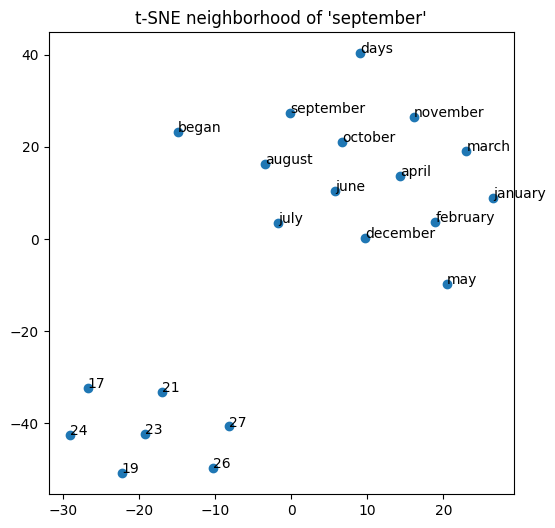

In [11]:
def plot_tsne_neighborhood(query: str, k: int = 20, random_state: int = 0):
    out = most_similar(query, k)
    if out["matched"] is None or not out["neighbors"]:
        print("Nothing to plot (OOV or empty neighbors).")
        return
    words = [out["matched"]] + [w for w, _ in out["neighbors"]]
    idxs = [stoi[w] for w in words if w in stoi]
    X = W[idxs].cpu().numpy()

    perp = max(5, min(10, len(words)-1))  # 소수 이웃일 때 안정적인 perplexity
    tsne = TSNE(n_components=2, init="pca", learning_rate="auto",
                perplexity=perp, random_state=random_state)
    Z = tsne.fit_transform(X)

    plt.figure(figsize=(6,6))
    plt.scatter(Z[:,0], Z[:,1])
    for (x,y), w in zip(Z, words):
        plt.text(x, y, w)
    plt.title(f"t-SNE neighborhood of '{out['matched']}'")
    plt.show()

plot_tsne_neighborhood("september", k=20, random_state=0)

# 간단 인터랙티브 질의
무엇을 하나요? 한 셀에서 여러 단어를 빠르게 테스트합니다.
Colab 콘솔 프롬프트에서 단어를 입력하고 Enter를 누르세요. 종료는 quit.

In [12]:
while True:
    q = input("Type a word (or 'quit'): ").strip()
    if q.lower() in ("q", "quit", "exit"):
        break
    show(q, k=10)

Type a word (or 'quit'): apple
Query: apple  (matched token: 'apple')
  google                0.519
  iphone                0.514
  ibm                   0.510
  computers             0.476
  ios                   0.475
  app                   0.465
  ipod                  0.462
  virtual               0.447
  microsoft             0.437
  phone                 0.436
Type a word (or 'quit'): quit


# 결과 저장: CSV & PNG
무엇을 하나요? 재현/보고용으로 CSV/이미지를 저장합니다.

Saved: neighbors_september_20251007_100805.csv


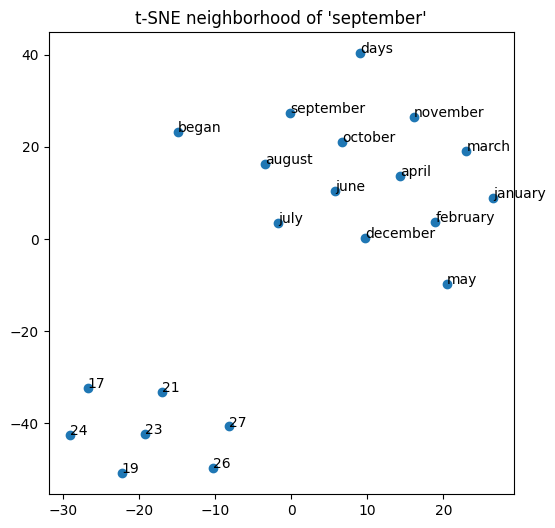

Saved: neighbors_september_20251007_100805.png


In [13]:
import csv, time

def export_neighbors(query: str, k: int = 20, prefix: str = "neighbors"):
    out = most_similar(query, k)
    ts = time.strftime("%Y%m%d_%H%M%S")
    csv_path = f"{prefix}_{out['matched']}_{ts}.csv" if out["matched"] else f"{prefix}_{query}_{ts}.csv"

    with open(csv_path, "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(["rank", "word", "cosine"])
        for i, (wrd, sc) in enumerate(out["neighbors"], 1):
            w.writerow([i, wrd, f"{sc:.6f}"])
    print("Saved:", csv_path)

    # 시각화도 파일로 저장
    words = [out["matched"]] + [w for w, _ in out["neighbors"]] if out["matched"] else []
    if words:
        idxs = [stoi[w] for w in words if w in stoi]
        X = W[idxs].cpu().numpy()
        perp = max(5, min(10, len(words)-1))
        Z = TSNE(n_components=2, init="pca", learning_rate="auto",
                 perplexity=perp, random_state=0).fit_transform(X)
        plt.figure(figsize=(6,6))
        plt.scatter(Z[:,0], Z[:,1])
        for (x,y), w in zip(Z, words):
            plt.text(x, y, w)
        plt.title(f"t-SNE neighborhood of '{out['matched']}'")
        png_path = f"{prefix}_{out['matched']}_{ts}.png"
        plt.savefig(png_path, dpi=150, bbox_inches="tight")
        plt.show()
        print("Saved:", png_path)

# 예시 저장
export_neighbors("september", k=20)

# 월 이름 빠른 점검 배치
무엇을 하나요? 12개월 이름을 한 번에 점검해 월 이웃이 잘 붙는지 살펴봅니다.

In [14]:
months = ["january","february","march","april","may","june",
          "july","august","september","october","november","december"]

for m in months:
    out = most_similar(m, topk=5)
    head = ", ".join([w for w,_ in out["neighbors"][:5]]) if out["neighbors"] else "OOV/None"
    print(f"{m:>10s} → {head}")

   january → february, june, december, november, april
  february → january, june, december, march, november
     march → november, february, april, june, august
     april → june, october, july, march, november
       may → february, june, december, april, july
      june → july, october, february, august, april
      july → june, august, december, april, october
    august → june, october, september, july, march
 september → october, august, june, november, january
   october → september, june, august, november, april
  november → october, march, january, february, april
  december → february, october, january, june, july
